# Goal: scrape movie budget data from Wikipedia
We can try achieving this in 2 ways:
1. Install Wikipedia library, which can provide us with 'summary' of every movie and do some amount of python string tricks and regex magic to find a sentence with the word 'budget' and try to extract some numbers surrounding that keyword. That may work, but we don't know if all of the summaries have the budget data, in what sentance that data is etc.
2. Scrape the budget data directly from Wikipedia. Every movie has an  info-box on the right side of the webiste with most important facts about it: Director, Screenplay, Actors... Budget!

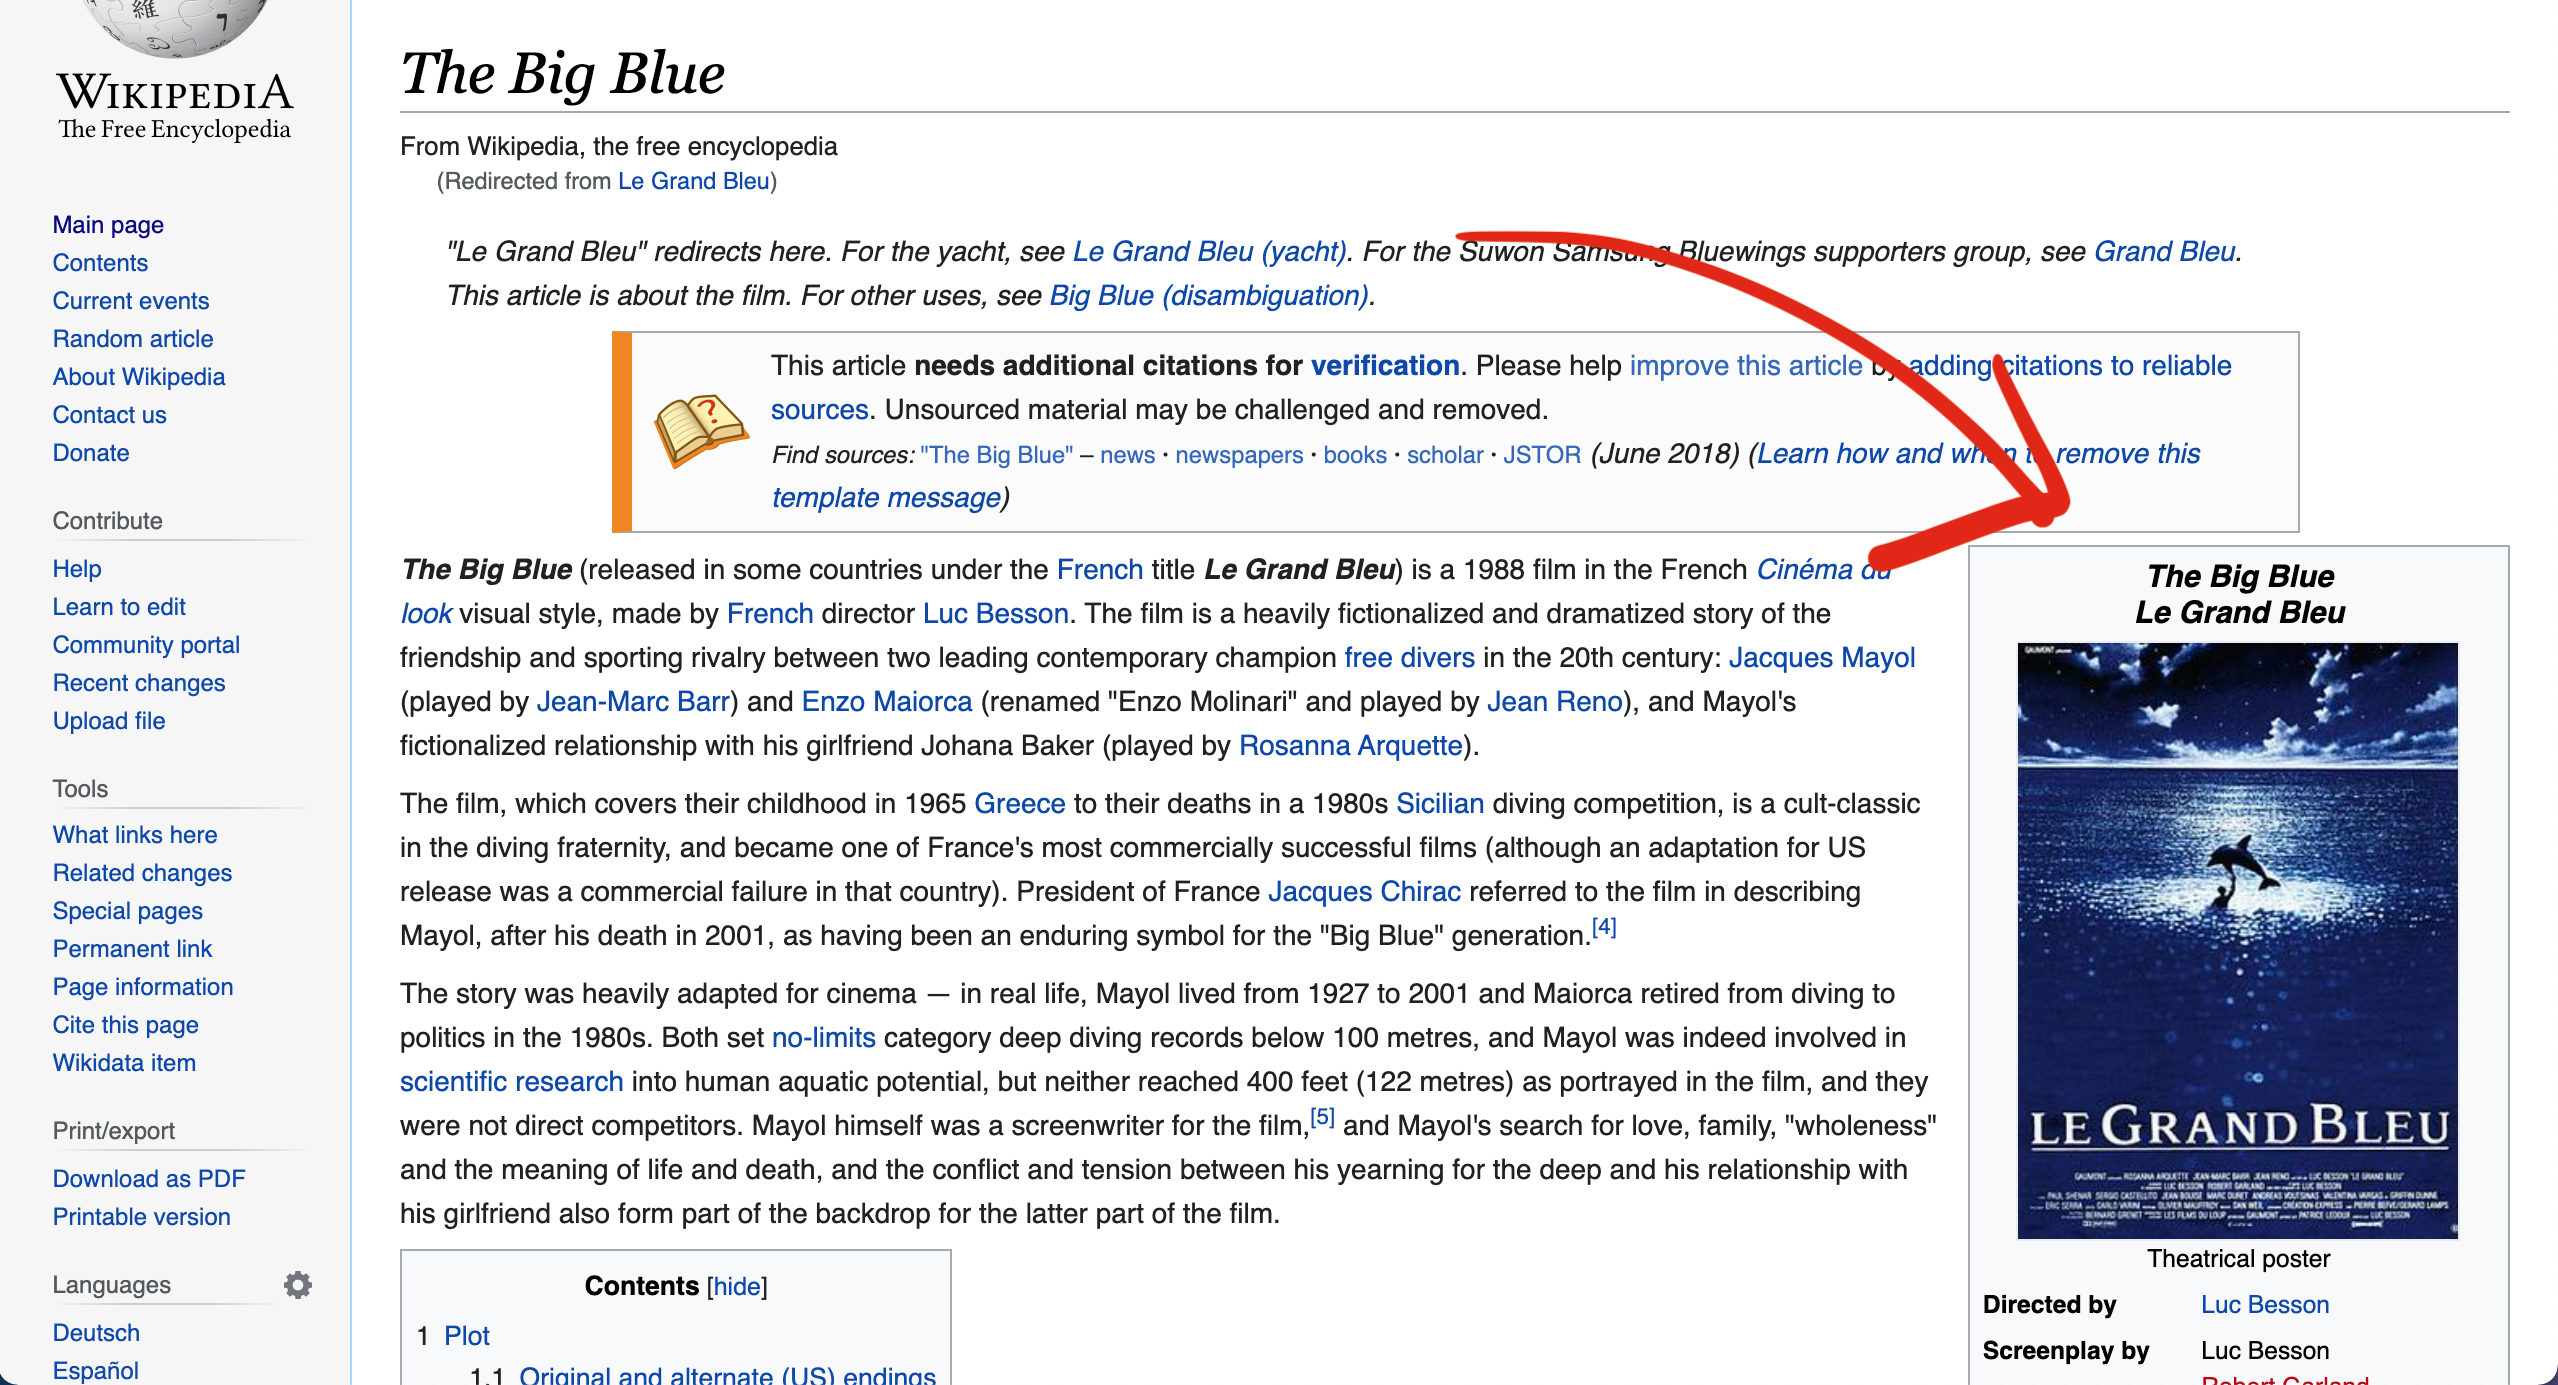

Number 2 sounds more fun, so lets get to it:

In [1]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib.request
from urllib.request import urlretrieve 
from urllib.request import urlopen, Request
import re

In [2]:
df = pd.read_csv('fandango_titles.csv', index_col=0)

<a id='step1'></a>

# 1. Lets make the movie titles more 'url - friendly'

In [3]:
# lets remove special characters and replace them with underscores, we're keeping the year!
df['title_urled'] = df['FILM'].str.replace('[^A-Za-z0-9]+', '_', regex=True).str.strip('_').str.lower()
df.head()

,FILM,title_urled
0,Avengers: Age of Ultron (2015),avengers_age_of_ultron_2015
1,Cinderella (2015),cinderella_2015
2,Ant-Man (2015),ant_man_2015
3,Do You Believe? (2015),do_you_believe_2015
4,Hot Tub Time Machine 2 (2015),hot_tub_time_machine_2_2015


To make life easier, I've only kept one column: the Films title - it's the original version of the column. I haven't removed the year - we're going to need it. In order to scrape the data for say one movie, we need a few things: 

1. URL to the movies Wikipedia page
2. Tag & class of an item we're looking for - we're going to scrape all of those elements into a list
3. Number of our desired data on that list



# 2. Lets scrape Wikipedia page of Ant-Man

In [4]:
# 2.1 lets have a look at Ant-Mans Wikipedia page html code:
url = "https://en.wikipedia.org/wiki/Ant-Man_(film)"
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Ant-Man (film) - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"64cbdea7-fa0f-4c12-a658-08d2ea79f1dd","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Ant-Man_(film)","wgTitle":"Ant-Man (film)","wgCurRevisionId":1048829220,"wgRevisionId":1048829220,"wgArticleId":36484005,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description matches Wikidata","Wikipedia pending changes protected pages","Good articles","Use American E

After inspecting the above content we found the budget data:
```

<th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">
          Budget
         </th>
         <td class="infobox-data">
          $130–169.3 million

```

We can clearly see a tag and class ``` <th class="infobox-label" ....> ``` for the word 'Budget' and ``` <td class="infobox-data"> ``` for the actual numbers. We're more interested in scraping the numbers but knowing how to find 'Budget' will be very helpful! **NOTICE: there's a difference in class: 'Budget' has a class of "infobox-label". The actual numbers have a class "infobox-data" !**

<a id='step22'></a>

In [5]:
# 2.2 Lets go trough box labels and find position of 'Budget':
response = requests.get("https://en.wikipedia.org/wiki/Ant-Man_(film)")
content = response.content
parser = BeautifulSoup(content, 'html.parser')
# this is the really important line we're creating a list of all 'th' tags with class="infobox-label":
tag_name = parser.find_all("th", class_="infobox-label")
len(tag_name)

17

Our list of ``` th ``` tags has 17 elements, we have to find the position of budget:

In [6]:
tag_name

[<th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Directed by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Screenplay by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Story by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Based on</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Produced by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Starring</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Cinematography</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Edited by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Music by</th>,
 <th class="infobox-label" s

Looks like it's the one before the last one! (index -2), double check:

In [7]:
tag_name[-2].text

'Budget'

Yep! Now we can actually scrape the numbers data using this knowledge!

In [8]:
# 2.3 print the infobox-data with that postion:    
response = requests.get("https://en.wikipedia.org/wiki/Ant-Man_(film)")
content = response.content
parser = BeautifulSoup(content, 'html.parser')
# here we're going to extract only the  one before the last element:
tag_numbers = parser.find_all("td", class_="infobox-data")[-2]
print(tag_numbers.text)

$130–169.3 million[2][3][4]


Voila, we'll deal with making it a real number later. Now a very important question: can we do that for every movie from our fandango dataframe? Lets check one more movie:

In [9]:
# 2.4 print the infobox-data with that postion:    
response = requests.get("https://en.wikipedia.org/wiki/Cinderella_(2015_Disney_film)")
content = response.content
parser = BeautifulSoup(content, 'html.parser')
# here we're going to extract only the  one before the last element:
tag_numbers = parser.find_all("td", class_="infobox-data")[-2]
print(tag_numbers.text)

Walt Disney


* We actually had to fiddle with the Wikipedia URL - it's path is ``` /Cinderella_(2015_Disney_film) ```
    * Ant-Man URL path was: ``` /Ant-Man_(film) ```
* **The fact that the path seems not standarized is going to make life harder for us**.
* On top of that, it looks like the element with index [-2] is not the budget! Lets look for the word budget:

In [10]:
# 2.5 Lets go trough box labels and find position of 'Budget':
response = requests.get("https://en.wikipedia.org/wiki/Cinderella_(2015_Disney_film)")
content = response.content
parser = BeautifulSoup(content, 'html.parser')
tag_name = parser.find_all("th", class_="infobox-label")
len(tag_name)

22

In [11]:
# 2.6 22 elements! Remember Ant-Man had only 17!(this will be important later on), where is budget?:
tag_name

[<th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Directed by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Screenplay by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Based on</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Produced by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Starring</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Cinematography</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Edited by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Music by</th>,
 <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;"><div style="display:inline-block; padding:0

In [12]:
tag_name[14].text

'Budget'

In [13]:
# 2.7 we found the word "Budget" at position 14, lets extract the numbers    
response = requests.get("https://en.wikipedia.org/wiki/Cinderella_(2015_Disney_film)")
content = response.content
parser = BeautifulSoup(content, 'html.parser')
# here we're going to extract only the  one before the last element:
tag_numbers = parser.find_all("td", class_="infobox-data")[14]
print(tag_numbers.text)

$84.21-95 million[5][6]



# 3. So... we have 2 problems:
1. URLs vary...a lot, sometimes there's a '(Film)' added at the end, special characters are sometimes replaced, sometimes not replaced... it's not fun
2. The list of all occurances of ``` <td class="infobox-data"> ``` has various lengths for different movies. So the budget numbers are going to be in various places of our list of elements...

# 4. Solution to 1st problem: 
We need a valid path to our desired article for every movie, pasting the contents of 'title_urled' into the url won't work. We could try modyfing them, but just the first two examples, prove that it's going to be a lot of hit and miss. **If only there was a way to use Wikipedias search box...** Actually... we're trying to do web scraping here, why don't we scrape the results of a search query? That should give us the link to the movie's wikipedia page. If we only had titles, we could run into some other articles, but we're using movie titles combined with their premiere years. Surely the first result is going to be the movie we're after!

**4.1 Lets look at search results page**

The URL path of Wikipedia search results is very simple and always very similar, lets look up a few examples: 
* something_2021
* i_hate_coriander
* coffee_2019

Here are the search results:

``` 
https://en.wikipedia.org/w/index.php?search=something_2021&title=Special:Search&profile=advanced&fulltext=1&ns0=1

https://en.wikipedia.org/w/index.php?search=i_hate_coriander_2000&title=Special:Search&profile=advanced&fulltext=1&ns0=1 

https://en.wikipedia.org/w/index.php?search=coffee_2019&title=Special:Search&profile=advanced&fulltext=1&ns0=1 

```

**4.2 Structure of search results url**


Results URL are always very similar and we can split the into 3 strings:

The standard beginning: ```https://en.wikipedia.org/w/index.php?search=```

our input: ```our_movie_title_and_year```

standard end/ path: ```&title=Special:Search&profile=advanced&fulltext=1&ns0=1```
   

**4.3 Modyfing the search results url**

Naturally the only thing that's changing is our input. Because at the very [beginning of this notebook](#step1) we made the movie titles 'url friendly' we can just paste them into the middle of search results url:

```https://en.wikipedia.org/w/index.php?search=``` + ```our_movie_title_and_year``` + ```&title=Special:Search&profile=advanced&fulltext=1&ns0=1```

That will provide us with search results for every title. The first result has to be our movie.  We have provided movie title combined with its premiere year - the chances are very slim for getting anthing else in the first result.

**4.4 Scraping the search results and finding the first search result link**

Now we have to scrape that result, to do that we'll recreate steps 2.1 - 2.3, but this time we'll be working on search results page: 
* we'll inspect the html of the whole 'search results' page
* find the element we're after (links)
* scrape all of those elements into a list
* then find the position of first search result on that list (you've probably already guessed it's not going to be the first element, there are a few links on that page before the first result)

```
search_query = df['title_urled']

```

Notice how we're joining 3 strings (with our search_query in the middle) to create an url:

url = ```"https://en.wikipedia.org/w/index.php?search="```+search_query+```"&title=Special:Search&profile=advanced&fulltext=1&ns0=1"```


```
html = urlopen(url)

soup = BeautifulSoup(html, 'lxml')

web_links = soup.find_all("a")
```
**the first result of our seach query is actually the tenth link on the results page:**
```
movie_path = web_links[10].get("href")  

```
Voila, we have a valind url path for every movie. Now, come the fun part: scraping the budget from those pages - remember we still have **problem no. 2!**

In [21]:
# lets try it on one of our movies:
search_query = 'cinderella_2015'
# Put the title into wikipedia search and extract the first link to the first result:(it's not the first link!!!)
url = "https://en.wikipedia.org/w/index.php?search="+search_query+"&title=Special:Search&profile=advanced&fulltext=1&ns0=1"
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
web_links = soup.find_all("a")
# the first result of our seach query is actually a tenth link on the results page:
movie_path = web_links[10].get("href") 
print(movie_path)

/wiki/Cinderella_(2015_Disney_film)



# 5. Solution to 2nd problem: 
Quick reminder what's the second problem: 

The list of all occurances of ``` <td class="infobox-data"> ``` has various lengths for different movies. So the budget numbers are going to be in various places of our list of elements...

Remember how we found the position of word 'Budget' in [step 2.2?](#step22) - that's how we're going to know the location of numbers data for every movie!

**5.1 let scrape all of the info-box labels into a list and check how long is that list:**

```
response = requests.get("https://en.wikipedia.org"+movie_path)
content = response.content
parser = BeautifulSoup(content, 'html.parser')
par_len = len(parser.find_all("th", class_="infobox-label"))

```
**5.2 let loop trough some of the elements in info-box labels list and find the word 'Budget'**

We don't need to loop trough the first elements of that list, they're always going to be Director, Actors, Music, Producers...etc. Lets start with 8 and work towards the end. **If we come across the 'Budget', we'll extract the infobox-data (attention infobox-data NOT infobox-label) with that position.**

```

for num in range(8,par_len):        
    tag_name = parser.find_all("th", class_="infobox-label")[num]
    if tag_name.text == 'Budget':  
        tag_numbers = parser.find_all("td", class_="infobox-data")[num]
        print(tag_numbers.text)

```

In [20]:
# looking up the position of word 'Budget' in infobox-labels list and extracting the numbers from infobox-data:
response = requests.get("https://en.wikipedia.org"+movie_path)
content = response.content
parser = BeautifulSoup(content, 'html.parser')
par_len = len(parser.find_all("th", class_="infobox-label"))
for num in range(8,par_len):        
    tag_name = parser.find_all("th", class_="infobox-label")[num]
    if tag_name.text == 'Budget':  
        tag_numbers = parser.find_all("td", class_="infobox-data")[num]
        print(tag_numbers.text)

$84.21-95 million[5][6]


# 6. create a function that combines everything from steps 4 and 5:

**6.1 Things to do by our function**

Our function will have to:
1. receive the input - 'title_urled'
2. put it inside the search results url (step 4.3)
3. scrape the search results links and find the first result link (step 4.4) that's the page of our movie
4. scrape the data of that page
5. find the position of budget, return the numbers data with that position
**6. We have to assume that some movies may not have a 'Budget' data -  we'll return None**

In [22]:
def scrape_money(df):
    # 1. Input:
    search_query = df['title_urled']
    # 2. Put the title into wikipedia search and extract the link to the first result:(it's not the first link!!!)
    url = "https://en.wikipedia.org/w/index.php?search="+search_query+"&title=Special:Search&profile=advanced&fulltext=1&ns0=1"
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    web_links = soup.find_all("a")
    # 3. the first result of our seach query is actually a tenth link on the results page:
    movie_path = web_links[10].get("href")   
    # 4. now lets scrape all of the infobox-labels into a list a check how long is that list:
    response = requests.get("https://en.wikipedia.org"+movie_path)
    content = response.content
    parser = BeautifulSoup(content, 'html.parser')
    par_len = len(parser.find_all("th", class_="infobox-label"))
    # 5. Loop trough infobox-labels list and find the position of 'Budget':
    for num in range(8,par_len):        
        tag_name = parser.find_all("th", class_="infobox-label")[num]
        if tag_name.text == 'Budget':  
            tag_numbers = parser.find_all("td", class_="infobox-data")[num]
            return tag_numbers.text
    # 6. If we can't find a budget:
    else:
        return None

# 7. Apply the function to our dataframe:
# WARNING - THIS CAN TAKE A WHILE!

In [23]:
df['budget'] = df.apply(scrape_money, axis=1)
df

,FILM,title_urled,budget
0,Avengers: Age of Ultron (2015),avengers_age_of_ultron_2015,\n$444–495.2 million (gross)[2][3]\n$365 milli...
1,Cinderella (2015),cinderella_2015,$84.21-95 million[5][6]
2,Ant-Man (2015),ant_man_2015,$130–169.3 million[2][3][4]
3,Do You Believe? (2015),do_you_believe_2015,$2.3 million[2]
4,Hot Tub Time Machine 2 (2015),hot_tub_time_machine_2_2015,$14–18 million[4][5]
...,...,...,...
140,Inside Out (2015),inside_out_2015,$175 million[2]
141,Mr. Holmes (2015),mr_holmes_2015,$10 million[4]
142,'71 (2015),71_2015,£8.1 million[2]
144,Gett: The Trial of Viviane Amsalem (2015),gett_the_trial_of_viviane_amsalem_2015,None


In [24]:
%timeit df['budget'] = df.apply(scrape_money, axis=1)

6min 12s ± 60 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


6 minutes and 12 seconds to get all the data. Now we only need to clean that column and make those numbers neat. I'll leave that for another day.